In [30]:
import torch
from models.encoder import Encoder
from models.decoder import Decoder
from config import *
from utils.load_data import load_dataset
import importlib

# === setup device ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === choose trial number to revisit ===
trial = 3  # change this to revisit old checkpoints
is_old_trial = trial < TRIAL

# === define dimensions for old trials ===
latent_dim_old = 3
p_dim_old = 1
s_dim_old = 1

# === dynamically select decoder architecture ===
if is_old_trial:
    Decoder = importlib.import_module("models.decoder_old").Decoder
    decoder = Decoder(s_dim_old, p_dim_old, latent_dim_old).to(device)
    latent_dim = latent_dim_old
    p_dim = p_dim_old
    s_dim = s_dim_old
    decoder_path = f"models/checkpoints/iteration_{trial}/decoder_ckpt_{trial}.pt"
    encoder = None  # no encoder in dummy trials
else:
    from models.decoder import Decoder
    from models.encoder import Encoder
    decoder = Decoder(S_DIM, P_DIM, LATENT_DIM).to(device)
    encoder = Encoder(S_DIM, P_DIM, LATENT_DIM).to(device)
    latent_dim = LATENT_DIM
    p_dim = P_DIM
    s_dim = S_DIM
    decoder_path = DECODER_SAVE_PATH

# === load decoder weights ===
decoder.load_state_dict(torch.load(decoder_path, map_location=device))
decoder.eval()

# === print decoder architecture ===
print("\n✅ Decoder Architecture:\n", decoder)


✅ Decoder Architecture:
 Decoder(
  (hidden_layers): Sequential(
    (0): Linear(in_features=12, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): ReLU()
  )
  (output_layer): Linear(in_features=32, out_features=4, bias=True)
)


/var/folders/9z/9fdpt4_148s8zzl9h0tr9dgw0000gn/T/ipykernel_920/2535323775.py:40: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  decoder.load_state_dict(torch.load(decoder_pat

In [31]:
# === load full dataset ===
P_all, S_all = load_dataset(DATA_PATH)
P_val = P_all[0].unsqueeze(0).to(device)   # shape: (1, 9)
S_true = S_all[0].cpu().numpy()            # shape: (4,)

# === check that P values are unique ===
P_unique = torch.unique(P_all, dim=0)
print(f"{len(P_unique)} unique P vectors out of {len(P_all)} total rows.")
if len(P_unique) == len(P_all):
    print("✅ All P values in the dataset are unique.")
else:
    print("⚠️ Some duplicate P values found in the dataset.")

21000 unique P vectors out of 21000 total rows.
✅ All P values in the dataset are unique.


In [32]:
import torch
from sklearn.cluster import KMeans
import numpy as np
from config import *

# === sampling function ===
def get_S_hats(P_val, num_samples=500):
    """
    Samples structure parameters S_hat from decoder conditioned on a fixed target P_val.
    """
    P_tensor = P_val.repeat(num_samples, 1).to(device)  # shape: (num_samples, 9)
    z_samples = torch.randn((num_samples, LATENT_DIM)).to(device)

    with torch.no_grad():
        S_hats = decoder(z_samples, P_tensor)

    return S_hats.cpu().numpy()  # shape: (num_samples, 4)

# === extract S-hat peaks using meanshift clustering function ===
def get_S_hat_peaks(S_hats, bandwidth=1.0):
    """
    Extracts the most likely structure parameters (modes) from the predicted S_hats
    using Kernel Density Estimation via the MeanShift algorithm.

    Args:
        S_hats (ndarray): Array of sampled structure parameters, shape (num_samples, S_dim)
        bandwidth (float): Controls the size of the region used to estimate density peaks

    Returns:
        ndarray: Coordinates of the mode centers in structure space, shape (num_modes, S_dim)

    Interpretation:
        These mode centers represent the CVAE’s most confident predictions for S given a fixed P.
        They can be passed through Max’s forward model to see how well they reproduce the original P.
    """
    from sklearn.cluster import MeanShift
    ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
    ms.fit(S_hats)
    return ms.cluster_centers_

<>:17: SyntaxWarning: invalid escape sequence '\h'
<>:31: SyntaxWarning: invalid escape sequence '\h'
<>:33: SyntaxWarning: invalid escape sequence '\h'
<>:17: SyntaxWarning: invalid escape sequence '\h'
<>:31: SyntaxWarning: invalid escape sequence '\h'
<>:33: SyntaxWarning: invalid escape sequence '\h'
/var/folders/9z/9fdpt4_148s8zzl9h0tr9dgw0000gn/T/ipykernel_920/241250672.py:17: SyntaxWarning: invalid escape sequence '\h'
  plt.title("KDE of $||\hat{S} - S_{true}||$")
/var/folders/9z/9fdpt4_148s8zzl9h0tr9dgw0000gn/T/ipykernel_920/241250672.py:31: SyntaxWarning: invalid escape sequence '\h'
  plt.scatter(S_pca[:, 0], S_pca[:, 1], alpha=0.3, label="Sampled $\hat{S}$")
/var/folders/9z/9fdpt4_148s8zzl9h0tr9dgw0000gn/T/ipykernel_920/241250672.py:33: SyntaxWarning: invalid escape sequence '\h'
  plt.title("Distribution of $\hat{S}$ in PCA space")


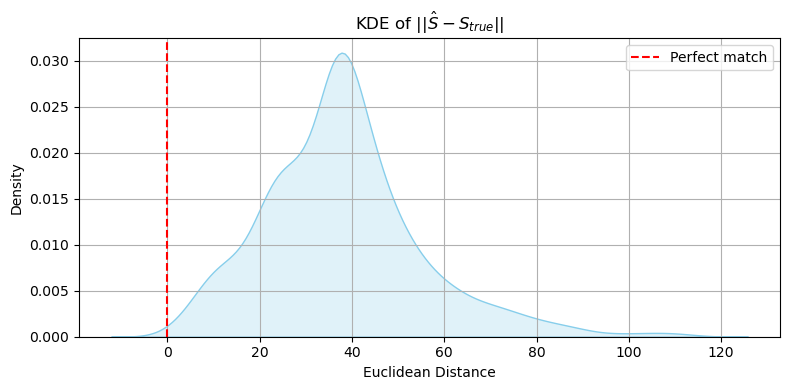

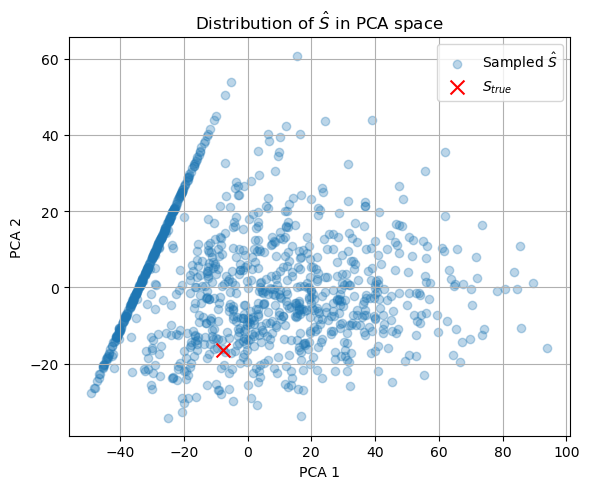

In [33]:
# === sample S_hat values ===
S_hats = get_S_hats(P_val, num_samples=1000)
S_hat_peaks = get_S_hat_peaks(S_hats, bandwidth=1.0)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# --- Sanitize distances ---
distances = np.linalg.norm(S_hats - S_true, axis=1).astype(np.float64)

# --- KDE of Euclidean distances ---
plt.figure(figsize=(8, 4))
sns.kdeplot(distances, fill=True, color='skyblue')
plt.axvline(0, color='red', linestyle='--', label="Perfect match")
plt.title("KDE of $||\hat{S} - S_{true}||$")
plt.xlabel("Euclidean Distance")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- PCA visualization of S_hat vs S_true ---
pca = PCA(n_components=2)
S_pca = pca.fit_transform(S_hats)
S_true_pca = pca.transform(S_true.reshape(1, -1))

plt.figure(figsize=(6, 5))
plt.scatter(S_pca[:, 0], S_pca[:, 1], alpha=0.3, label="Sampled $\hat{S}$")
plt.scatter(S_true_pca[0, 0], S_true_pca[0, 1], color='red', marker='x', s=100, label="$S_{true}$")
plt.title("Distribution of $\hat{S}$ in PCA space")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
